In [1]:
import h5py
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import time

# Additional imports for deep learning models
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [2]:
# read dateset
path = '/Users/amir/PycharmProjects/Medfair/MEDFAIR/'

demo_data = pd.read_excel(path + 'BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx')

images_path = os.path.join(path, '/MEDFAIR/BrEaST-Lesions_USG-images_and_masks/')


demo_data

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification
0,1,case001.png,case001_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign
1,2,case002.png,case002_tumor.png,NaN,0.006462,NaN,homogeneous: fat,not available,not available,oval,...,hypoechoic,no,no,no,no,Dysplasia&Fibroadenoma,4b,confirmed by biopsy,Intramammary lymph node,benign
2,3,case003.png,case003_tumor.png,NaN,0.006944,56.0,heterogeneous: predominantly fat,no,nipple discharge,oval,...,hyperechoic,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign
3,4,case004.png,case004_tumor.png,NaN,0.007812,43.0,homogeneous: fibroglandular,no,no,round,...,hypoechoic,no,no,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign
4,5,case005.png,case005_tumor.png,NaN,0.007812,67.0,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,complex cystic/solid,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,case252.png,case252_tumor.png,NaN,0.006944,18.0,homogeneous: fibroglandular,palpable,no,oval,...,hypoechoic,no,no,no,no,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign
252,253,case253.png,case253_tumor.png,NaN,0.007812,64.0,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,...,anechoic,enhancement,no,no,yes,Fat necrosis&Breast scar (surgery),2,confirmed by follow-up care,not applicable,benign
253,254,case254.png,case254_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,no,no,irregular,...,hypoechoic,shadowing,no,no,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant
254,255,case255.png,case255_tumor.png,NaN,0.006944,42.0,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,heterogeneous,shadowing,no,intraductal,no,Suspicion of malignancy&Mastitis,4c,confirmed by biopsy,Ductal carcinoma in situ (DCIS),malignant


In [3]:
# add image path to the metadata
pathlist = demo_data['Image_filename'].values.tolist()
paths = ['/Users/amir/PycharmProjects/Medfair/MEDFAIR/BrEaST-Lesions_USG-images_and_masks/' + i for i in pathlist]
demo_data['Path'] = paths

In [4]:
# remove age/sex == null 
demo_data = demo_data[~demo_data['Age'].isnull()]
demo_data

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification,Path
0,1,case001.png,case001_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
2,3,case003.png,case003_tumor.png,NaN,0.006944,56.0,heterogeneous: predominantly fat,no,nipple discharge,oval,...,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
3,4,case004.png,case004_tumor.png,NaN,0.007812,43.0,homogeneous: fibroglandular,no,no,round,...,no,no,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
4,5,case005.png,case005_tumor.png,NaN,0.007812,67.0,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
5,6,case006.png,case006_tumor.png,NaN,0.007812,56.0,heterogeneous: predominantly fat,no,HRT/hormonal contraception,irregular,...,no,no,intraductal,no,Suspicion of malignancy&Intraductal papilloma&...,4b,confirmed by biopsy,Fibrosclerosis,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,case252.png,case252_tumor.png,NaN,0.006944,18.0,homogeneous: fibroglandular,palpable,no,oval,...,no,no,no,no,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
252,253,case253.png,case253_tumor.png,NaN,0.007812,64.0,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,...,enhancement,no,no,yes,Fat necrosis&Breast scar (surgery),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
253,254,case254.png,case254_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,no,no,irregular,...,shadowing,no,no,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
254,255,case255.png,case255_tumor.png,NaN,0.006944,42.0,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,shadowing,no,intraductal,no,Suspicion of malignancy&Mastitis,4c,confirmed by biopsy,Ductal carcinoma in situ (DCIS),malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...


In [5]:
# Grouping ages by decades
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Assign age categories to the 'Age' column
demo_data['Age_Category'] = pd.cut(demo_data['Age'], bins=age_bins, labels=age_labels, right=False)
demo_data

/var/folders/nn/fgf_xpts7y18yb4cb3hx57k80000gn/T/ipykernel_57024/2435842104.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_data['Age_Category'] = pd.cut(demo_data['Age'], bins=age_bins, labels=age_labels, right=False)


,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification,Path,Age_Category
0,1,case001.png,case001_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60
2,3,case003.png,case003_tumor.png,NaN,0.006944,56.0,heterogeneous: predominantly fat,no,nipple discharge,oval,...,no,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60
3,4,case004.png,case004_tumor.png,NaN,0.007812,43.0,homogeneous: fibroglandular,no,no,round,...,no,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,41-50
4,5,case005.png,case005_tumor.png,NaN,0.007812,67.0,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,61-70
5,6,case006.png,case006_tumor.png,NaN,0.007812,56.0,heterogeneous: predominantly fat,no,HRT/hormonal contraception,irregular,...,no,intraductal,no,Suspicion of malignancy&Intraductal papilloma&...,4b,confirmed by biopsy,Fibrosclerosis,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,case252.png,case252_tumor.png,NaN,0.006944,18.0,homogeneous: fibroglandular,palpable,no,oval,...,no,no,no,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,11-20
252,253,case253.png,case253_tumor.png,NaN,0.007812,64.0,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,...,no,no,yes,Fat necrosis&Breast scar (surgery),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,61-70
253,254,case254.png,case254_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,no,no,irregular,...,no,no,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60
254,255,case255.png,case255_tumor.png,NaN,0.006944,42.0,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,no,intraductal,no,Suspicion of malignancy&Mastitis,4c,confirmed by biopsy,Ductal carcinoma in situ (DCIS),malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,41-50


In [6]:
# split subjects to different age groups
demo_data['Age_multi'] = demo_data['Age'].values.astype('int')
demo_data['Age_multi'] = np.where(demo_data['Age_multi'].between(-1,19), 0, demo_data['Age_multi'])
demo_data['Age_multi'] = np.where(demo_data['Age_multi'].between(20,39), 1, demo_data['Age_multi'])
demo_data['Age_multi'] = np.where(demo_data['Age_multi'].between(40,59), 2, demo_data['Age_multi'])
demo_data['Age_multi'] = np.where(demo_data['Age_multi'].between(60,79), 3, demo_data['Age_multi'])
demo_data['Age_multi'] = np.where(demo_data['Age_multi']>=80, 4, demo_data['Age_multi'])

demo_data['Age_binary'] = demo_data['Age'].values.astype('int')
demo_data['Age_binary'] = np.where(demo_data['Age_binary'].between(-1, 60), 0, demo_data['Age_binary'])
demo_data['Age_binary'] = np.where(demo_data['Age_binary']>= 60, 1, demo_data['Age_binary'])
demo_data

/var/folders/nn/fgf_xpts7y18yb4cb3hx57k80000gn/T/ipykernel_57024/2237739249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_data['Age_multi'] = demo_data['Age'].values.astype('int')
/var/folders/nn/fgf_xpts7y18yb4cb3hx57k80000gn/T/ipykernel_57024/2237739249.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_data['Age_multi'] = np.where(demo_data['Age_multi'].between(-1,19), 0, demo_data['Age_multi'])
/var/folders/nn/fgf_xpts7y18yb4cb3hx57k80000gn/T/ipykernel_57024/2237739249.py:4: SettingWith

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification,Path,Age_Category,Age_multi,Age_binary
0,1,case001.png,case001_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60,2,0
2,3,case003.png,case003_tumor.png,NaN,0.006944,56.0,heterogeneous: predominantly fat,no,nipple discharge,oval,...,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60,2,0
3,4,case004.png,case004_tumor.png,NaN,0.007812,43.0,homogeneous: fibroglandular,no,no,round,...,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,41-50,2,0
4,5,case005.png,case005_tumor.png,NaN,0.007812,67.0,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,61-70,3,1
5,6,case006.png,case006_tumor.png,NaN,0.007812,56.0,heterogeneous: predominantly fat,no,HRT/hormonal contraception,irregular,...,no,Suspicion of malignancy&Intraductal papilloma&...,4b,confirmed by biopsy,Fibrosclerosis,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,case252.png,case252_tumor.png,NaN,0.006944,18.0,homogeneous: fibroglandular,palpable,no,oval,...,no,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,11-20,0,0
252,253,case253.png,case253_tumor.png,NaN,0.007812,64.0,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,...,yes,Fat necrosis&Breast scar (surgery),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,61-70,3,1
253,254,case254.png,case254_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,no,no,irregular,...,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60,2,0
254,255,case255.png,case255_tumor.png,NaN,0.006944,42.0,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,no,Suspicion of malignancy&Mastitis,4c,confirmed by biopsy,Ductal carcinoma in situ (DCIS),malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,41-50,2,0


In [7]:
# convert to binary labels
labels = demo_data['Classification'].values.copy()
labels[labels == 'malignant'] = '1'
labels[labels != '1'] = '0'

labels = labels.astype('int')

demo_data['binaryLabel'] = labels
demo_data

/var/folders/nn/fgf_xpts7y18yb4cb3hx57k80000gn/T/ipykernel_57024/855793808.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_data['binaryLabel'] = labels


,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Interpretation,BIRADS,Verification,Diagnosis,Classification,Path,Age_Category,Age_multi,Age_binary,binaryLabel
0,1,case001.png,case001_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60,2,0,0
2,3,case003.png,case003_tumor.png,NaN,0.006944,56.0,heterogeneous: predominantly fat,no,nipple discharge,oval,...,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60,2,0,0
3,4,case004.png,case004_tumor.png,NaN,0.007812,43.0,homogeneous: fibroglandular,no,no,round,...,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,41-50,2,0,0
4,5,case005.png,case005_tumor.png,NaN,0.007812,67.0,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,61-70,3,1,1
5,6,case006.png,case006_tumor.png,NaN,0.007812,56.0,heterogeneous: predominantly fat,no,HRT/hormonal contraception,irregular,...,Suspicion of malignancy&Intraductal papilloma&...,4b,confirmed by biopsy,Fibrosclerosis,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,case252.png,case252_tumor.png,NaN,0.006944,18.0,homogeneous: fibroglandular,palpable,no,oval,...,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,11-20,0,0,0
252,253,case253.png,case253_tumor.png,NaN,0.007812,64.0,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,...,Fat necrosis&Breast scar (surgery),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,61-70,3,1,0
253,254,case254.png,case254_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,no,no,irregular,...,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,51-60,2,0,1
254,255,case255.png,case255_tumor.png,NaN,0.006944,42.0,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,Suspicion of malignancy&Mastitis,4c,confirmed by biopsy,Ductal carcinoma in situ (DCIS),malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,41-50,2,0,1


In [8]:
def split_811(all_meta, patient_ids):
    sub_train, sub_val_test = train_test_split(patient_ids, test_size=0.2, random_state=0)
    sub_val, sub_test = train_test_split(sub_val_test, test_size=0.5, random_state=0)
    train_meta = all_meta[all_meta.CaseID.isin(sub_train)]
    val_meta = all_meta[all_meta.CaseID.isin(sub_val)]
    test_meta = all_meta[all_meta.CaseID.isin(sub_test)]
    return train_meta, val_meta, test_meta

sub_train, sub_val, sub_test = split_811(demo_data, np.unique(demo_data['CaseID']))

In [9]:
sub_train.to_csv('/Users/amir/PycharmProjects/Medfair/MEDFAIR/split/new_train.csv')
sub_val.to_csv('/Users/amir/PycharmProjects/Medfair/MEDFAIR/split/new_val.csv')
sub_test.to_csv('/Users/amir/PycharmProjects/Medfair/MEDFAIR/split/new_test.csv')

(537, 485, 3)


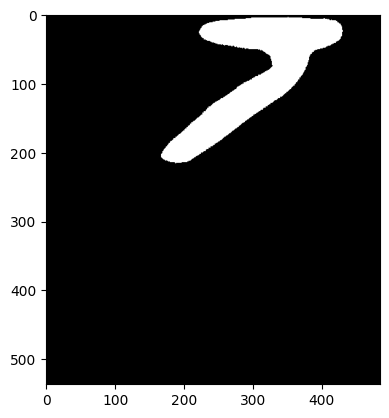

In [10]:
# you can have a look of some examples here
img = cv2.imread('/Users/amir/PycharmProjects/Medfair/MEDFAIR/BrEaST-Lesions_USG-images_and_masks/case001_tumor.png')
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['binaryLabel']
        protected_attr = self.dataframe.iloc[idx]['Age_Category']

        if self.transform:
            image = self.transform(image)

        return image, label, protected_attr

In [12]:
# Define data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
# Create datasets and dataloaders
train_dataset = CustomDataset(dataframe=sub_train, transform=transform)
val_dataset = CustomDataset(dataframe=sub_val, transform=transform)
test_dataset = CustomDataset(dataframe=sub_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the models
model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 2)

model_vgg16 = models.vgg16(pretrained=True)
num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, 2)

model_densenet = models.densenet121(pretrained=True)
num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs, 2)

model_mobilenet = models.mobilenet_v2(pretrained=True)
num_ftrs = model_mobilenet.classifier[1].in_features
model_mobilenet.classifier[1] = nn.Linear(num_ftrs, 2)

model_alexnet = models.alexnet(pretrained=True)
num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs, 2)


/Users/amir/Documents/Projects/Python/Medfair/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/amir/Documents/Projects/Python/Medfair/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/amir/Documents/Projects/Python/Medfair/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.

In [14]:
# Criterion and optimizers
criterion = nn.CrossEntropyLoss()
optimizers = [
    optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9),
    optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)
]

In [15]:
# Function to train the model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

In [16]:
def demographic_parity(labels, preds, protected_attrs):
    dp = {}
    for group in np.unique(protected_attrs):
        group_mask = (protected_attrs == group)
        dp[group] = np.mean(preds[group_mask])
    return dp

def equalized_odds(labels, preds, protected_attrs):
    eo = {}
    for group in np.unique(protected_attrs):
        group_mask = (protected_attrs == group)
        group_labels = labels[group_mask]
        group_preds = preds[group_mask]
        tpr = np.sum((group_labels == 1) & (group_preds == 1)) / np.sum(group_labels == 1)
        fpr = np.sum((group_labels == 0) & (group_preds == 1)) / np.sum(group_labels == 0)
        eo[group] = {'TPR': tpr, 'FPR': fpr}
    return eo

In [ ]:
# Train the models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

models_list = [model_resnet18, model_vgg16, model_densenet, model_mobilenet, model_alexnet]
optimizers = [optim.SGD(model.parameters(), lr=0.001, momentum=0.9) for model in models_list]
model_names = ['ResNet18', 'VGG16', 'DenseNet121', 'MobileNetV2', 'AlexNet']

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

trained_models = []

for model, optimizer,model_name in zip(models_list, optimizers, model_names):
    model = model.to(device)
    print(f"Training {model_name}...")
    trained_model = train_model(model, dataloaders, criterion, optimizer, num_epochs=25)
    trained_models.append(trained_model)
    torch.save(trained_model.state_dict(), f'model_{model_name}.pth')
    print(f"{model_name} trained and saved.")

Training ResNet18...
Epoch 0/24
----------
train Loss: 0.7409 Acc: 0.5497
val Loss: 0.6942 Acc: 0.5238

Epoch 1/24
----------
train Loss: 0.5957 Acc: 0.6725
val Loss: 0.6806 Acc: 0.5714

Epoch 2/24
----------
train Loss: 0.4980 Acc: 0.7778
val Loss: 0.6549 Acc: 0.4762

Epoch 3/24
----------
train Loss: 0.3616 Acc: 0.9474
val Loss: 0.6470 Acc: 0.5238

Epoch 4/24
----------
train Loss: 0.2721 Acc: 0.9649
val Loss: 0.6530 Acc: 0.5714

Epoch 5/24
----------
train Loss: 0.2155 Acc: 0.9591
val Loss: 0.5970 Acc: 0.6190

Epoch 6/24
----------
train Loss: 0.1716 Acc: 0.9883
val Loss: 0.5985 Acc: 0.6667

Epoch 7/24
----------
train Loss: 0.1480 Acc: 0.9825
val Loss: 0.5740 Acc: 0.6190

Epoch 8/24
----------
train Loss: 0.0778 Acc: 0.9942
val Loss: 0.6335 Acc: 0.5714

Epoch 9/24
----------
train Loss: 0.0767 Acc: 1.0000
val Loss: 0.5934 Acc: 0.6190

Epoch 10/24
----------
train Loss: 0.0542 Acc: 0.9942
val Loss: 0.6104 Acc: 0.6667

Epoch 11/24
----------
train Loss: 0.0433 Acc: 1.0000
val Loss: 0

In [ ]:
# Evaluate bias
def evaluate_bias(model, dataloader, protected_attr_name):
    model.eval()
    all_preds = []
    all_labels = []
    all_protected_attrs = []

    with torch.no_grad():
        for data in dataloader:
            inputs = data[0].to(device)
            labels = data[1].to(device)
            protected_attrs = data[2]

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_protected_attrs.extend(protected_attrs)  # Convert protected_attrs to list

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_protected_attrs = np.array(all_protected_attrs)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    dp = demographic_parity(all_labels, all_preds, all_protected_attrs)
    eo = equalized_odds(all_labels, all_preds, all_protected_attrs)

    age_group_accuracies = {}
    age_group_f1_scores = {}

    for group in np.unique(all_protected_attrs):
        group_mask = (all_protected_attrs == group)
        group_labels = all_labels[group_mask]
        group_preds = all_preds[group_mask]

        group_accuracy = accuracy_score(group_labels, group_preds)
        group_f1 = f1_score(group_labels, group_preds, average='weighted')

        age_group_accuracies[group] = group_accuracy
        age_group_f1_scores[group] = group_f1

    return accuracy, f1, age_group_accuracies, age_group_f1_scores, dp, eo

In [ ]:
# Evaluating the models
def print_fairness_metrics(model_name, accuracy, f1, age_group_accuracies, age_group_f1_scores, dp, eo):
    print(f"\n=== Fairness Metrics for {model_name} ===")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Overall F1-Score: {f1:.4f}")

    print("\nAccuracy by Age Group:")
    for age_group, group_accuracy in age_group_accuracies.items():
        print(f"  Age group {age_group}: {group_accuracy:.4f}")

    print("\nF1-Score by Age Group:")
    for age_group, group_f1 in age_group_f1_scores.items():
        print(f"  Age group {age_group}: {group_f1:.4f}")

    print("\nDemographic Parity:")
    dp_df = pd.DataFrame.from_dict(dp, orient='index', columns=['Demographic Parity'])
    print(dp_df)

    print("\nEqualized Odds:")
    eo_df = pd.DataFrame.from_dict(eo, orient='index')
    print(eo_df)

for model, model_name in zip(trained_models, model_names):
    accuracy, f1, age_group_accuracies, age_group_f1_scores, dp, eo = evaluate_bias(model, test_loader, protected_attr_name='Age_Category')
    print_fairness_metrics(model_name, accuracy, f1, age_group_accuracies, age_group_f1_scores, dp, eo)